# Amazon Review Sentiment Analysis and modelling Using Biderectional LSTM

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
pd.options.display.max_rows = None

# 2. Import Amazon Product Reviews Dataset and Basic Cleaning

In [3]:
p = 0.3
df = pd.read_csv('../input/amazon-product-reviews/Reviews.csv',skiprows=lambda i: i>0 and rn.random() > p)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...
4,20,B001GVISJM,A3IV7CL2C13K2U,Greg,0,0,5,1318032000,Home delivered twizlers,Candy was delivered very fast and was purchase...


In [4]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   8
Text                      0
dtype: int64

In [5]:
df.dropna(axis=0,inplace=True)

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.shape

(170778, 10)

### We can see the ammount of scoring of each review

In [8]:
df.Score.value_counts()

5    109201
4     24098
1     15714
3     12760
2      9005
Name: Score, dtype: int64

### Then we classify score values to sentiment. For score values above 3, we classify them into positive sentiment, and for score values below 3 we classify them into negative sentiment

In [9]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [10]:
df['Score_New']=df['Score'].apply(score_round)


In [11]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score_New
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
2,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0
4,20,B001GVISJM,A3IV7CL2C13K2U,Greg,0,0,5,1318032000,Home delivered twizlers,Candy was delivered very fast and was purchase...,1


In [12]:
df.Score_New.value_counts()

1    146059
0     24719
Name: Score_New, dtype: int64

In [13]:
review=df.copy()

In [14]:
review.shape

(170778, 11)

### Creating additional features to see number of words in every text and summary review

In [15]:
review['number_of_Text_words'] = review['Text'].str.lower().str.split().apply(len)
review['number_of_Summary_words'] = review['Summary'].str.lower().str.split().apply(len)
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score_New,number_of_Text_words,number_of_Summary_words
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,3
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,2
2,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1,26,2
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0,42,2
4,20,B001GVISJM,A3IV7CL2C13K2U,Greg,0,0,5,1318032000,Home delivered twizlers,Candy was delivered very fast and was purchase...,1,29,3


# 3. Analysis and Visualization

## 3.1. Wordclouds For all text and Summary Reviews

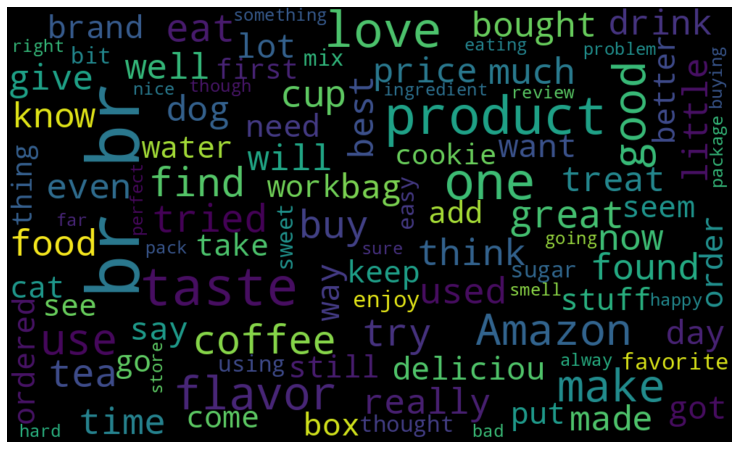

In [16]:
txt = ' '.join(rev for rev in review.Text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()


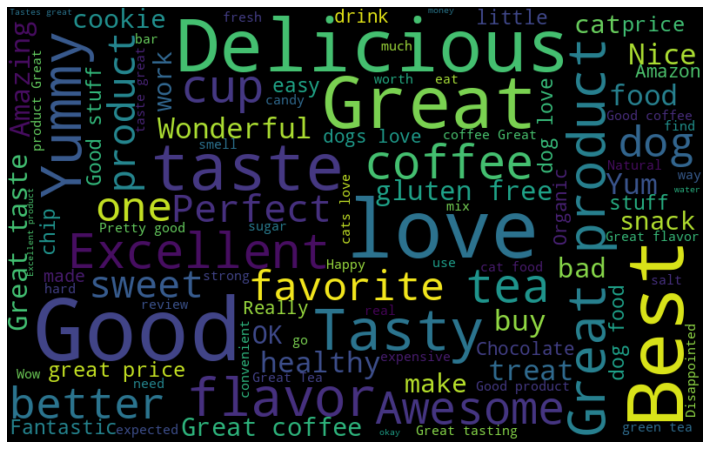

In [17]:
txt = ' '.join(rev for rev in review.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.2. Wordclouds For Each Positive and Negative Sentiment Reviews

## Positive Sentiment

In [18]:
review_positive = review[review['Score_New']==1]

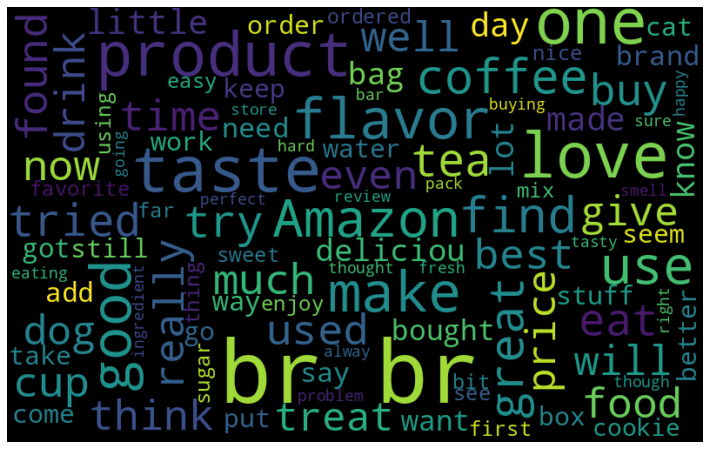

In [19]:
txt = ' '.join(rev for rev in review_positive.Text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

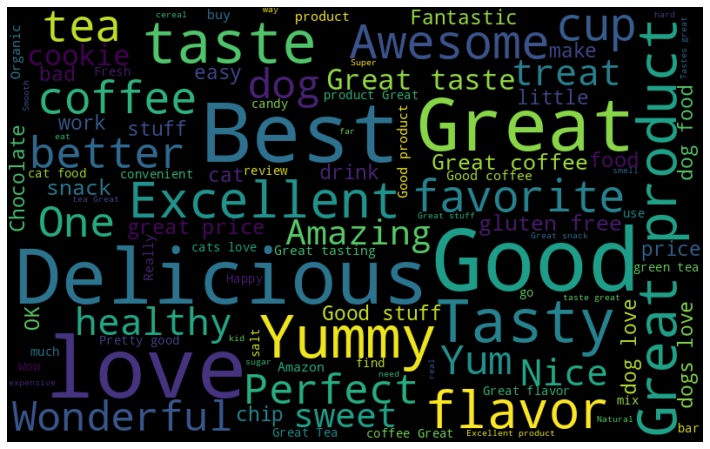

In [20]:
txt = ' '.join(rev for rev in review_positive.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)

plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We have better view when we see our review summary's wordcloud. We can see that for postive sentiment review, the most common words are 'Best','Yummy','Awesome','Great', etc as shown in picture above.

## Negative Sentiment

In [21]:
review_negative = review[review['Score_New']==0]

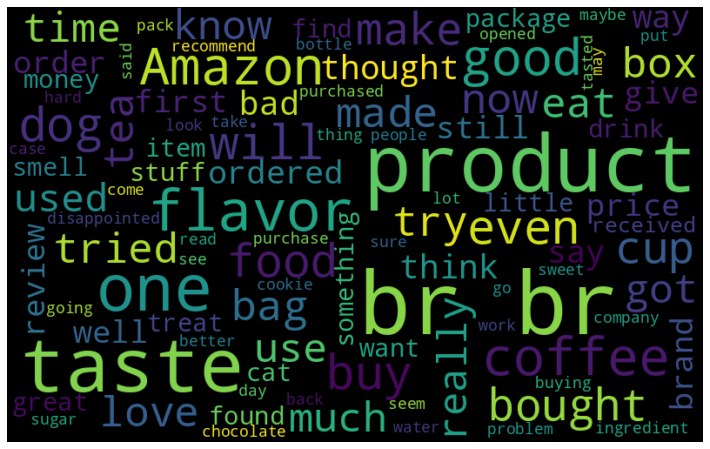

In [22]:
txt = ' '.join(rev for rev in review_negative.Text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

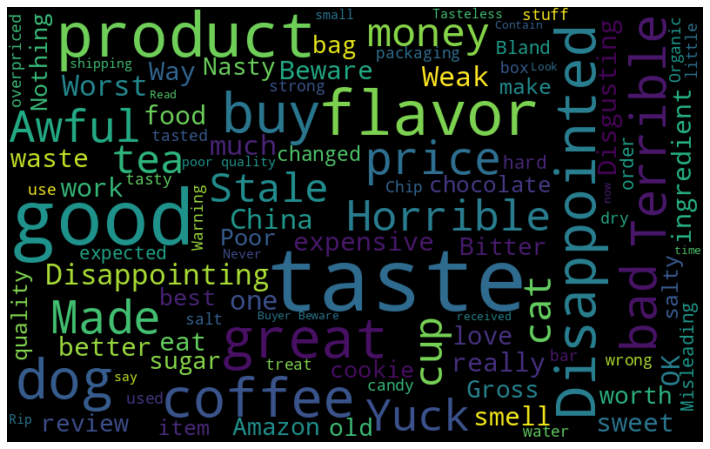

In [23]:
txt = ' '.join(rev for rev in review_negative.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Same as before, we have better view when we see our review summary's wordcloud. We can see that for negative sentiment review, the most common words are 'Disappointed', 'Horrible', 'Terrible', 'Dissapointing', etc as shown in picture above.

### But we can see that there are words like 'good' and  'great'. They maybe come from sentences like "...not great" or "...not good".

## 3.3. Distribution of Sentiment Reviews

In [24]:
review_vis = review.copy()
review_vis['Score_New'] = review_vis['Score_New'].replace({0 : 'negative'})
review_vis['Score_New'] = review_vis['Score_New'].replace({1 : 'positive'})


<AxesSubplot:xlabel='Score_New', ylabel='count'>

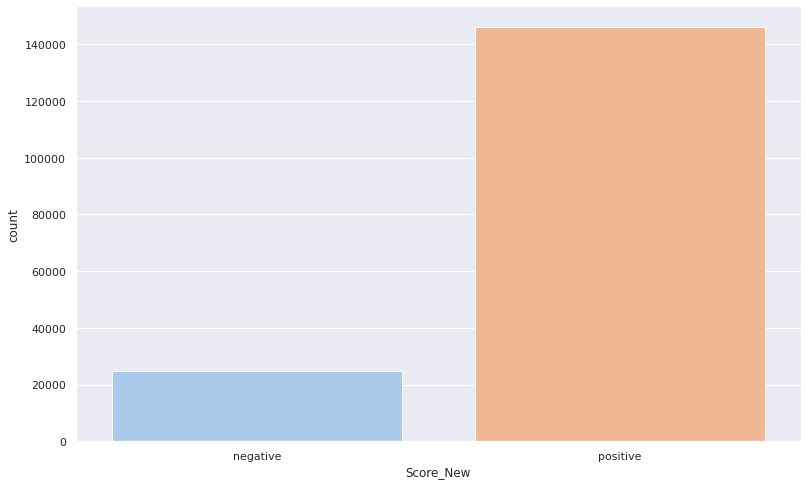

In [25]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='Score_New',data=review_vis)


# 4. Data Cleaning for Sentiment Processing

In [26]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### We make a function to clean some basic characters

In [27]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [28]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make a function to clean and remove emoji (if there is some)

In [29]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make a function to clean unnecessary whitespaces

In [30]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make a function to clean and remove symbols

In [31]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string  

### We make a function to remove punctuation

In [32]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### If necessary we can use stemming or lemmatization for advanced cleaning. We will try implementing the function later.

In [33]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)


In [34]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all cleaning functions

In [35]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].map(Stemming)

In [36]:
cleaning(review,'Text')
cleaning(review,'Summary')

In [37]:
review[['Text','Summary']].head()

,Text,Summary
0,product arriv label jumbo salt peanutsth peanu...,advertis
1,look secret ingredi robitussin believ found go...,cough medicin
2,right most sprout cat eat grass love rotat aro...,yay barley
3,love eat good watch tv look movi sweet like tr...,poor tast
4,candi deliv fast purchas reason price home bou...,home deliv twizler


# 5. Text Tokenizing and Modelling

In [38]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 5.1. Split our data to train and test data

In [39]:
# random split train and test 
index = df.index
review['random_number'] = np.random.randn(len(index))
train = review[review['random_number'] <= 0.8]
test = review[review['random_number'] > 0.8]


In [40]:
train.shape

(134498, 14)

In [41]:
test.shape

(36280, 14)

## 5.2. We tokenize our review summary using tensorflow tokenizer

In [42]:
max_length=100
vocab_size=13000
embedding_dim=64
trunc_type="post"
oov_tok="<OOV>"
padding_type="post"


In [43]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train['Text'])

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train['Text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, 
                                truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test['Text'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, 
                               truncating=trunc_type)

In [44]:
training_padded[1]

array([ 110,  740, 1393,   44,   20, 1472,    8, 2244,  177, 5517, 2495,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [45]:
print(training_sequences[0])

[9, 220, 406, 4053, 126, 1, 211, 141, 119, 114, 2642, 133, 2364, 1116, 1341, 2815, 9, 4053]


## 5.3. Bidirectional LSTM Modelling

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.preprocessing import sequence
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score    
from tensorflow.python.keras import models, layers, optimizers   
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [47]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(256, dropout=0.3)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

2022-04-19 01:45:34.967479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 01:45:34.968606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 01:45:34.969308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 01:45:34.970139: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           832000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,489,921
Trainable params: 1,489,921
Non-trainable params: 0
_________________________________________________________________


### Using Adam as optimizer

In [48]:
adam=Adam(learning_rate=0.0001)

In [49]:
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'] )

### Model Training

In [50]:
history=model.fit(training_padded,train['Score_New'], epochs=12, batch_size=256,
                  verbose = 1,callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)],
                  validation_data=(testing_padded,test['Score_New']))

2022-04-19 01:45:40.568171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
526/526 [==============================] - 560s 1s/step - loss: 0.3710 - accuracy: 0.8610 - val_loss: 0.2713 - val_accuracy: 0.8822
Epoch 2/12
526/526 [==============================] - 560s 1s/step - loss: 0.2472 - accuracy: 0.8973 - val_loss: 0.2351 - val_accuracy: 0.9020
Epoch 3/12
526/526 [==============================] - 557s 1s/step - loss: 0.2238 - accuracy: 0.9089 - val_loss: 0.2270 - val_accuracy: 0.9072
Epoch 4/12
526/526 [==============================] - 555s 1s/step - loss: 0.2118 - accuracy: 0.9144 - val_loss: 0.2209 - val_accuracy: 0.9109
Epoch 5/12
526/526 [==============================] - 557s 1s/step - loss: 0.2041 - accuracy: 0.9181 - val_loss: 0.2186 - val_accuracy: 0.9109
Epoch 6/12
526/526 [==============================] - 552s 1s/step - loss: 0.1978 - accuracy: 0.9208 - val_loss: 0.2231 - val_accuracy: 0.9134
Epoch 7/12
526/526 [==============================] - 556s 1s/step - loss: 0.1930 - accuracy: 0.9226 - val_loss: 0.2131 - val_accuracy: 0.9137

## 5.4. Model's Performance Evaluation

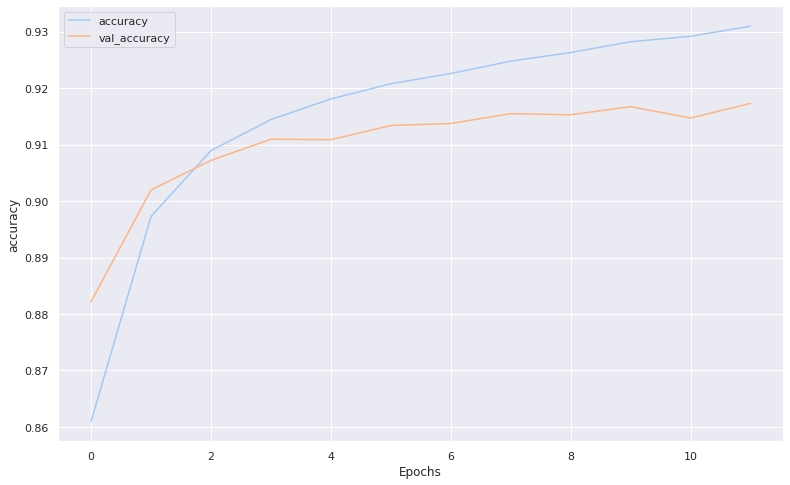

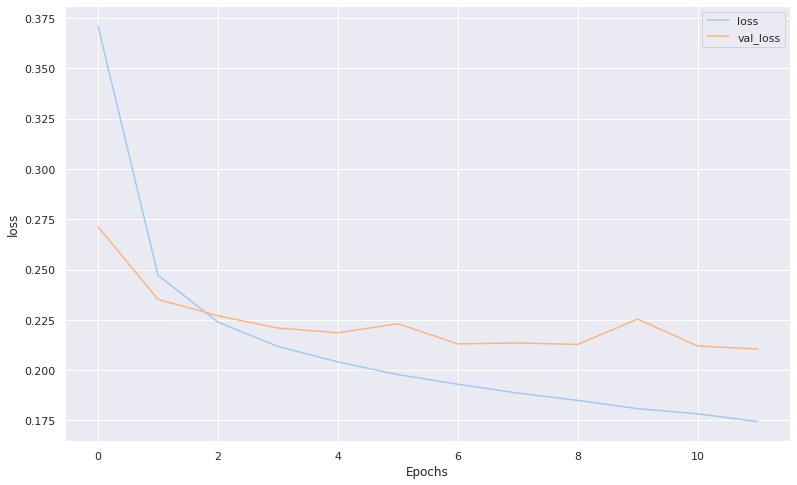

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [52]:
def Review(sentence):
   sequences = tokenizer.texts_to_sequences(sentence)
   padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

   prob=model.predict(padded)
   if prob>=0.8:
     print(5)
   elif prob>=0.6:
     print(4)
   elif prob>=0.4:
     print(3) 
   elif prob>=0.2:
     print(2)   
   else:
       print(1)

In [53]:
sentence=['Good Product and it fits me']
Review(sentence)

5


In [54]:
sentence=['this is worst thing ever']
Review(sentence)


1


In [55]:
# Predicting the Test set results
y_pred = model.predict(testing_padded)
y_pred = (y_pred > 0.5)
X_test=testing_padded
y_test=test['Score_New']

In [56]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
 
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.917282
Precision: 0.936909
Recall: 0.968332
F1 score: 0.952361
ROC AUC: 0.793672
[[ 3282  2020]
 [  981 29997]]


In [58]:
#Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69      5302
           1       0.94      0.97      0.95     30978

    accuracy                           0.92     36280
   macro avg       0.85      0.79      0.82     36280
weighted avg       0.91      0.92      0.91     36280



<AxesSubplot:>

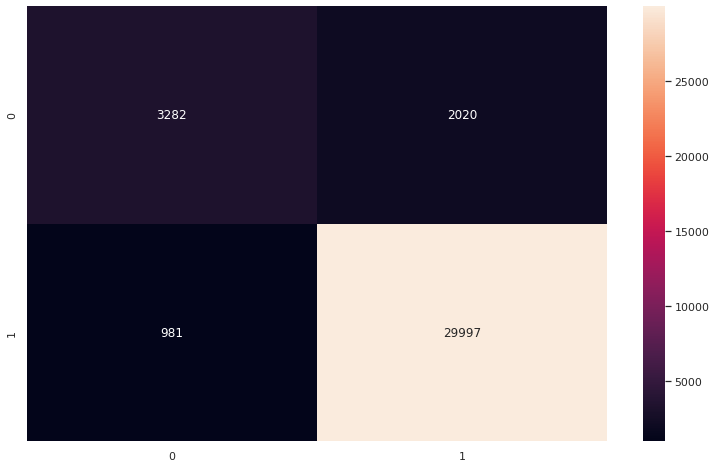

In [59]:
#Confusion Matrix
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt='')

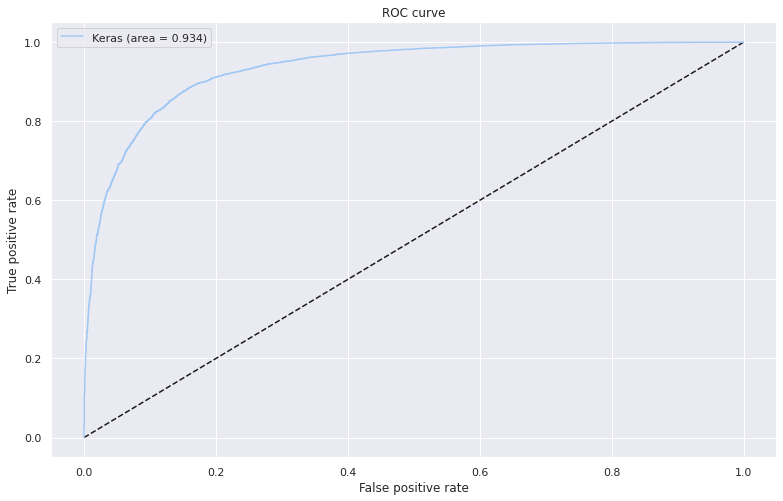

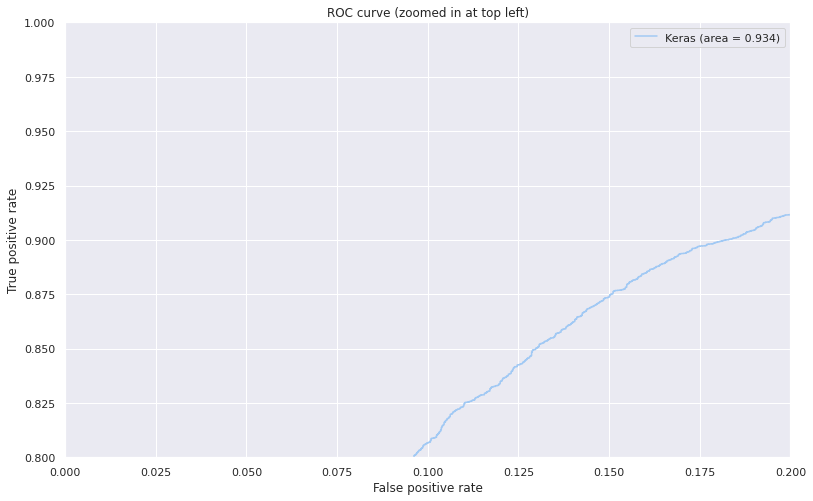

In [60]:
#ROC Curve

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()